In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sg
import requests
from PIL import Image

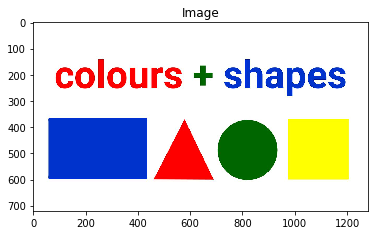

Image Max Value: 255 Image Min Value: 0


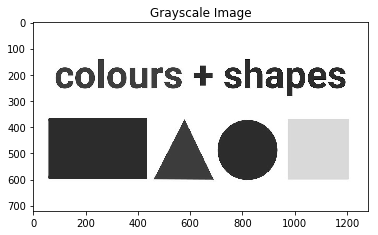

Image Max Value: 1050.6 Image Min Value: -1050.6000000000001
Image Max Value: 1050.6 Image Min Value: -1050.6000000000001
Image Max Value 255.0 Image Min Value: 0.0
Image Max value 255.0 Image Min Value: 0.0


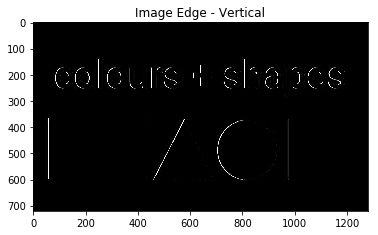

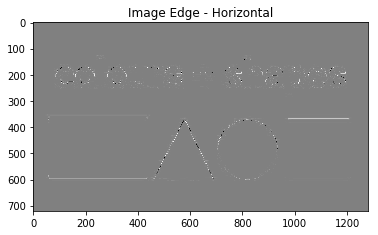

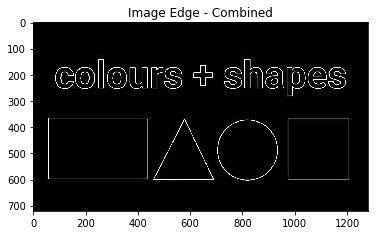

In [15]:
url = 'https://i.ytimg.com/vi/BqKXHIRwGbs/maxresdefault.jpg'
resp = requests.get(url, stream=True).raw
img = Image.open(resp)

img = np.array(img)

plt.title("Image")
plt.imshow(img)
plt.show()

img = img.astype(np.int16)
print(f"Image Max Value: {np.amax(img)} Image Min Value: {np.amin(img)}")

rgb2gray = lambda rgb: np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

img_gray = rgb2gray(img)

plt.title("Grayscale Image")
plt.imshow(img_gray, cmap="gray")
plt.show()

sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

img_edge_x = sg.convolve(img_gray, sobel_x, mode="same")
img_edge_y = sg.convolve(img_gray, sobel_y, mode="same")

print(f"Image Max Value: {np.amax(img_edge_x)} Image Min Value: {np.amin(img_edge_y)}")
print(f"Image Max Value: {np.amax(img_edge_y)} Image Min Value: {np.amin(img_edge_y)}")

img_edge = (img_edge_x**2 + img_edge_y**2)**.5

img_edge_x[img_edge_x > 255] = 255
img_edge_x[img_edge_x < 0] = 0

img_edge_y[img_edge_y > 255] = 255
img_edge_y[img_edge_y < 0] = 0

img_edge[img_edge > 255] = 255
img_edge[img_edge < 0] = 0

print(f"Image Max Value {np.amax(img_edge_x)} Image Min Value: {np.amin(img_edge_x)}")
print(f"Image Max value {np.amax(img_edge_y)} Image Min Value: {np.amin(img_edge_y)}")

img_edge_x = img_edge_x.astype(np.uint8)
img_edge_y = img_edge_y.astype(np.int8)
img_edge = img_edge.astype(np.uint8)

plt.title("Image Edge - Vertical")
plt.imshow(img_edge_x, cmap="gray")
plt.show()

plt.title("Image Edge - Horizontal")
plt.imshow(img_edge_y, cmap="gray")
plt.show()

plt.title("Image Edge - Combined")
plt.imshow(img_edge, cmap="gray")
plt.show()

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [20]:
torch.manual_seed(1)

mnist_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
mnist_data = list(mnist_data)
mnist_train = mnist_data[:4096]
mnist_val = mnist_data[4096:5120]

In [21]:
select_CNN = True

if not select_CNN:
    
    class MNISTClassifier(nn.Module):
        
        def __init__(self):
            super(MNISTClassifier, self).__init__()
            self.fc1 = nn.Linear(28*28, 50)
            self.fc2 = nn.Linear(50, 20)
            self.fc3 = nn.Linear(20, 10)
            
        def forward(self, img):
            flattened = img.view(-1, 28*28)
            activation1 = F.relu(self.fc1(flattened))
            activation2 = F.relu(self.fc2(activation1))
            return self.fc3(activation2)
        
        print("Artificial Neural Network Architeture (aka MLP) Selected")
        
else:
    
    class MNISTClassifier(nn.Module):
        
        def __init__(self):
            super(MNISTClassifier, self).__init__()
            self.conv1 = nn.Conv2d(1, 5, 5)
            self.pool = nn.MaxPool2d(2, 2)
            self.conv2 = nn. Conv2d(5, 10, 5)
            self.fc1 = nn.Linear(160, 32)
            self.fc2 = nn.Linear(32, 10)
            
        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = x.view(-1, 160)
            x = F.relu(self.fc1(x))
            return self.fc2(x)
    
        print("Convolutional Neural Network Achitecture Selected")

Convolutional Neural Network Achitecture Selected


In [25]:
def get_accuracy(model, train=False):
    data = mnist_train if train else mnist_val
    
    correct = 0
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=64):
        output = model(imgs)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    
    return correct / total

In [23]:
def train(model, data, batch_size=64, num_epochs=1):
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    
    iters, losses, train_acc, val_acc = [], [], [], []
    
    n = 0
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            iters.append(n)
            losses.append(float(loss)/batch_size)
            train_acc.append(get_accuracy(model, train=True))
            val_acc.append(get_accuracy(model, train=False))
            n += 1
            
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()
    
    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc="best")
    plt.show()
    
    print(f"Final Training Accuracy: {train_acc[-1]}")
    print(f"Final Validation Accuracy; {val_acc[-1]}")

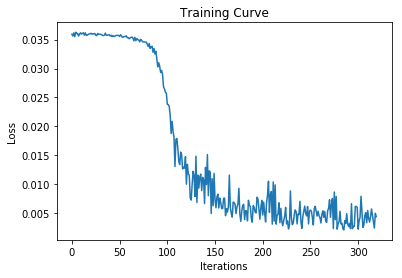

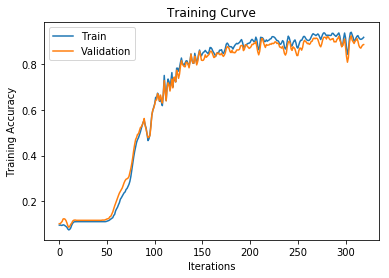

Final Training Accuracy: 0.91748046875
Final Validation Accuracy; 0.8857421875


In [26]:
model = MNISTClassifier()
train(model, mnist_train, num_epochs=5)

In [28]:
kernels = model.conv1.weight.detach()
print(kernels.shape)

torch.Size([5, 1, 5, 5])


tensor([[ 0.0045,  0.1364, -0.1805,  0.0373, -0.2260],
        [-0.0751, -0.1390,  0.0546,  0.0112, -0.1202],
        [-0.1602, -0.1758, -0.2669, -0.0469,  0.0784],
        [ 0.0547,  0.1384, -0.0588,  0.0679, -0.0843],
        [ 0.0935,  0.2632,  0.2667,  0.1363,  0.0418]])


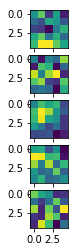

In [29]:
kernels = kernels.cpu()
print(kernels[0][0])

fig, axarr = plt.subplots(kernels.size(0))
for idx in range(kernels.size(0)):
    axarr[idx].imshow(kernels[idx][0])